<a href="https://colab.research.google.com/github/CS7140/PA-5/blob/main/Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 Image Classification with CNN

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.distribute import MirroredStrategy
from tensorflow.math import confusion_matrix

In [2]:
strategy = MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Train Model
The CIFAR10 dataset consists of 50000 images which are 32x32 pixels with RGB (3) channels at each pixel. The images fall into 10 categories: `{0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}`. 

Based on this, the input shape of the model must be (32,32,3) and the output layer must be 10 nodes (for 10 categories).
The output/Y data is one-hot encoded for categorization.

All model execution is occuring within a MirroredStrategy scope in order to ensure operations occur on the GPU for faster tensor operations.

The model architecture begins with three convolution+pooling layers for the images with increasing number of filter kernels of size (3,3) and pooling with (2, 2) stride. The convolution layer serves to extract features via essentially randomly generated kernels and pooling serves to downsample the images for better generalization and reduction of noise. 

Once gone through the Convolutional layers and pooling layers, The data passes through 3 fully connected Dense layers, with the final layer being a 10 node output layer for the classification into 10 categories. Giving the output layer activation function `softmax` instead of `sigmoid` resulted in about a ~1% improvement in test accuracy so I used that in the final layer.

Dropout layers are included after pooling and after each Dense layer in order to regularize and prevent overfitting given a high number of epochs. After trying a few variations, an increase in dropout after Dense layers gave about ~1% better results.

This model was fit using 150 epochs and a learning rate of 0.002. The momentum hyperparameter is set to 0.5 which accelerates gradient descent and dampens unwanted oscillations in loss and accuracy.

In [3]:
with strategy.scope():

    (trainX, trainY), (testX, testY) = cifar10.load_data()

    trainX = trainX.astype('float32')
    testX = testX.astype('float32')

    #normalize training and test data to range between 0 and 1
    trainX = trainX / 255
    testX = testX / 255

    trainY = to_categorical(trainY)
    testY = to_categorical(testY)

    print(trainX.shape)
    print(trainY.shape)

    model = Sequential()
    model.add(Conv2D(40, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32,32,3)))
    model.add(Conv2D(40, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(80, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(80, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(120, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(120, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))


    opt = SGD(lr=0.002, momentum=0.5)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    model_history = model.fit(trainX, trainY, epochs=150, batch_size=32, validation_data=(testX, testY), verbose=2)

170500096/170498071 [==============================] - 4s 0us/step
(50000, 32, 32, 3)
(50000, 10)
Epoch 1/150
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/re

Below are an example of predictions being made using the model and some training data, visualized as the images the tensors represent.

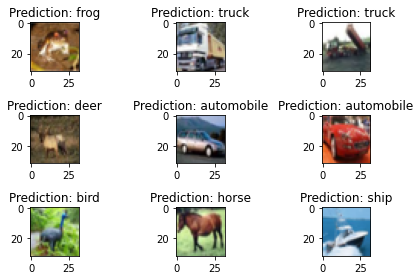

In [4]:
# plot predictions for first few images
labelDict = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}
preds = [labelDict[np.argmax(i)] for i in model.predict(trainX[:9])]
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.title('Prediction: ' + preds[i])
    plt.imshow(trainX[i])
plt.tight_layout()
plt.show()

# Evaluate Model Performance

The performance of the network in making categorical predictions of the images is quite good. On the training dataset, the predictions are 90.8% accurate and on the test dataset the accuracy is 84.5%. 

We can see that past 85 epochs, the loss and accuracy of predictions for test data stops improving and plateus while the training data predictions continue improving and its loss continued decreasing and accuracy increasing. Because the testing loss is plateued, this indicates that after 85 epochs the model can stop training because there is no more information it can gain to help with test predictions. Without dropout, it is likely that the model would overfit after passing 85 epochs.

We can see in the confusion matrix and bar-graph below that the categories with the worst precision and recall are for 'cat', 'dog' and 'bird', with 'cat' being the worst. It is likely that images of cats, dogs and birds share similar features and so all perform poorly in this model because those features are not brought forward by this model's convlutions and pooling. We can see that often a cat is classified as a dog and vice-versa. 'Automobile' did however perform the best out of all the categories along with runners up 'ship' and 'truck'. Although ships, trucks, and automobiles also often were misclassified with each other, likely due to shared features.

In [5]:
loss, acc = model.evaluate(testX, testY, verbose=0)
print('The model test accuracy is:', (acc * 100.0))
print('The model test loss is:', loss)

The model test accuracy is: 84.16000008583069
The model test loss is: 0.543189287185669


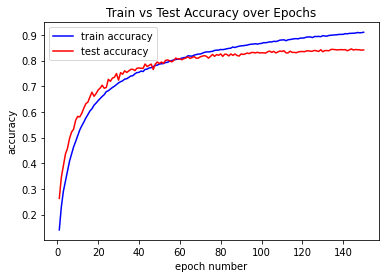

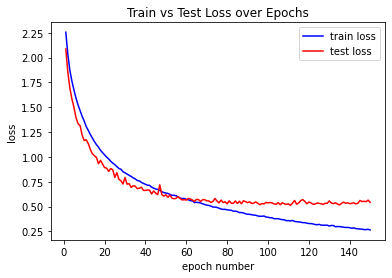

In [6]:
plt.title("Train vs Test Accuracy over Epochs")
plt.plot(range(1,151), model_history.history['accuracy'], 'b-', label='train accuracy')
plt.plot(range(1,151), model_history.history['val_accuracy'], 'r-', label='test accuracy')
plt.ylabel("accuracy")
plt.xlabel("epoch number")
plt.legend()
plt.show()

plt.title("Train vs Test Loss over Epochs")
plt.plot(range(1,151), model_history.history['loss'], 'b-', label='train loss')
plt.plot(range(1,151), model_history.history['val_loss'], 'r-', label='test loss')
plt.ylabel("loss")
plt.xlabel("epoch number")
plt.legend()
plt.show()

In [68]:
def groupedBarPlot(list1, list2, classes, title, ylabel):
    '''
    plots grouped bar plot of 2 lists, over the classes
    
    :param list1: list 1 of data
    :param list2: list 2 of data
    :param classes: classes of x axis
    :param title: graph title
    :param ylabel: y axis label
    '''

    labels = classes
    bern = list1
    mult = list2

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    ax.bar(x - width / 2, bern, width, label='Precision')
    ax.bar(x + width / 2, mult, width, label='Recall')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()

    plt.show()

Columns are Predictions, Rows are Actual:
            airplane  automobile     bird      cat     deer      dog     frog    horse     ship    truck  Recall
airplane     847.000      14.000   34.000   17.000   11.000    2.000    7.000    7.000   31.000   30.000   0.847
automobile     6.000     922.000    3.000    4.000    2.000    3.000    5.000    0.000    7.000   48.000   0.922
bird          41.000       1.000  745.000   37.000   45.000   55.000   56.000   13.000    6.000    1.000   0.745
cat           13.000       5.000   46.000  674.000   37.000  147.000   46.000   16.000    7.000    9.000   0.674
deer           6.000       1.000   36.000   38.000  830.000   19.000   44.000   24.000    1.000    1.000   0.830
dog            8.000       0.000   19.000  102.000   30.000  807.000   12.000   21.000    0.000    1.000   0.807
frog           4.000       1.000   25.000   36.000   10.000   10.000  909.000    3.000    1.000    1.000   0.909
horse          8.000       0.000   11.000   28.000   3

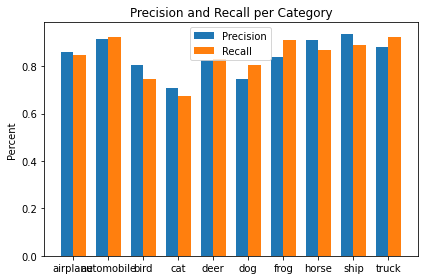

In [71]:
preds = [np.argmax(i) for i in model.predict(testX)]
actual = [np.argmax(i) for i in testY]
colNames = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# predictins are columns, actual are rows
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
confMtrx = pd.DataFrame(confusion_matrix(actual, preds).numpy(), columns=colNames)
confMtrx.index=colNames
print("Columns are Predictions, Rows are Actual:")

truePos = pd.DataFrame(pd.Series(np.diag(confMtrx), index=[confMtrx.index]))
rowSums = pd.DataFrame(confMtrx.sum(axis=1))
colSums = pd.DataFrame(confMtrx.sum(axis=0))

# calc precision and recall per category
recallList = pd.DataFrame(truePos[0].tolist()) / pd.DataFrame(rowSums[0].tolist())
precisionList = pd.DataFrame(truePos[0].tolist()) / pd.DataFrame(colSums[0].tolist())
recallList.index=colNames
precisionList.index=colNames

pList = np.array(precisionList)
precDict = {}
c = 0
for col in colNames:
    precDict[col] = round(pList[c][0],3)
    c += 1

# add prec and recall to confusion matrix
confMtrx['Recall'] = recallList
confMtrx = confMtrx.append(precDict, ignore_index=True)
confMtrx.index=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck','Precision']
print(confMtrx)

# recall vs precision bar-graph
groupedBarPlot(precisionList[0].tolist(), recallList[0].tolist(), colNames, "Precision and Recall per Category", "Percent")